# Load and Prepare PM2.5 Station Data

In [4]:
import pandas as pd

# Load PM2.5 CSV
csv_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind\2019_All_sites_air_quality.csv"
df = pd.read_csv(csv_path, usecols=[
    "sample_point_id", "sp_name", "latitude", "longitude",
    "sample_datetime", "param_name", "value", "param_short_name"
])

# Filter PM2.5 on 27 Dec 2019
df['sample_datetime'] = pd.to_datetime(df['sample_datetime'], dayfirst=True)
filtered_df = df[(df['sample_datetime'] >= '2019-12-27') & (df['sample_datetime'] < '2019-12-28')]
pm25_df = filtered_df[filtered_df['param_short_name'] == 'PM2.5'].dropna(subset=['latitude', 'longitude', 'value']).copy()
pm25_df['datetime_rounded'] = pm25_df['sample_datetime'].dt.round('1H')
print(pm25_df)


        sample_point_id    sp_name   latitude   longitude     sample_datetime  \
147828            10219  Churchill -38.304314  146.414932 2019-12-27 00:00:00   
147829            10219  Churchill -38.304314  146.414932 2019-12-27 01:00:00   
147830            10219  Churchill -38.304314  146.414932 2019-12-27 02:00:00   
147831            10219  Churchill -38.304314  146.414932 2019-12-27 03:00:00   
147832            10219  Churchill -38.304314  146.414932 2019-12-27 04:00:00   
...                 ...        ...        ...         ...                 ...   
731312            10011  Traralgon -38.194283  146.531464 2019-12-27 19:00:00   
731323            10011  Traralgon -38.194283  146.531464 2019-12-27 20:00:00   
731334            10011  Traralgon -38.194283  146.531464 2019-12-27 21:00:00   
731345            10011  Traralgon -38.194283  146.531464 2019-12-27 22:00:00   
731356            10011  Traralgon -38.194283  146.531464 2019-12-27 23:00:00   

                         pa

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_13128\3313144613.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pm25_df['datetime_rounded'] = pm25_df['sample_datetime'].dt.round('1H')


# Load AOD Data and Build Spatial Index

In [6]:
import numpy as np
from netCDF4 import Dataset
from datetime import datetime, timedelta
from scipy.spatial import cKDTree

# Load AOD
file_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD\MERRA2_400.inst3_2d_gas_Nx.20191227.nc4"
aod_ds = Dataset(file_path, 'r')
aod_data = aod_ds['AODANA'][:]     # shape (8, 361, 576)
aod_lats = aod_ds['lat'][:]
aod_lons = aod_ds['lon'][:]
aod_times = aod_ds['time'][:]

# Time handling
aod_base_time = datetime(2019, 12, 27)
aod_timestamps = [aod_base_time + timedelta(minutes=int(t)) for t in aod_times]

# KDTree for AOD
lon_grid, lat_grid = np.meshgrid(aod_lons, aod_lats)
aod_coords = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])
aod_tree = cKDTree(aod_coords)
print(aod_tree)

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_13128\2536008641.py:12: RuntimeWarning: invalid value encountered in cast
  aod_times = aod_ds['time'][:]
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_13128\2536008641.py:12: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = aod_ds['time'][:]


# Load Wind and Meteorological Data

In [7]:
wind_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind\MERRA2_400.tavg3_3d_asm_Nv.20191227.nc4"
wind_ds = Dataset(wind_path)

U = wind_ds['U'][:, 0, :, :]
V = wind_ds['V'][:, 0, :, :]
T = wind_ds['T'][:, 0, :, :]
RH = wind_ds['RH'][:, 0, :, :]
wind_lats = wind_ds['lat'][:]
wind_lons = wind_ds['lon'][:]
wind_times = wind_ds['time'][:]  # in hours
wind_base_time = datetime(2019, 12, 27)
wind_timestamps = [wind_base_time + timedelta(hours=int(t)) for t in wind_times]

# KDTree for Wind
wind_lon_grid, wind_lat_grid = np.meshgrid(wind_lons, wind_lats)
wind_coords = np.column_stack([wind_lat_grid.ravel(), wind_lon_grid.ravel()])
wind_tree = cKDTree(wind_coords)


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_13128\1581276465.py:10: RuntimeWarning: invalid value encountered in cast
  wind_times = wind_ds['time'][:]  # in hours
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_13128\1581276465.py:10: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  wind_times = wind_ds['time'][:]  # in hours


# Match AOD + Wind to Each PM2.5 Station

In [8]:
matched_data = []

for _, row in pm25_df.iterrows():
    point = [row['latitude'], row['longitude']]
    dt = row['datetime_rounded']

    # AOD match
    aod_time_idx = np.argmin([abs((dt - at).total_seconds()) for at in aod_timestamps])
    aod_flat = aod_data[aod_time_idx].ravel()
    _, aod_idx = aod_tree.query(point)
    aod_value = aod_flat[aod_idx]

    # Wind match
    wind_time_idx = np.argmin([abs((dt - wt).total_seconds()) for wt in wind_timestamps])
    u = U[wind_time_idx].ravel()[aod_idx]
    v = V[wind_time_idx].ravel()[aod_idx]
    temp = T[wind_time_idx].ravel()[aod_idx]
    rh = RH[wind_time_idx].ravel()[aod_idx]
    wind_speed = np.sqrt(u**2 + v**2)

    matched_data.append({
        'datetime': dt,
        'station': row['sp_name'],
        'lat': row['latitude'],
        'lon': row['longitude'],
        'PM2.5': row['value'],
        'AOD': aod_value,
        'U': u,
        'V': v,
        'wind_speed': wind_speed,
        'temp': temp,
        'rh': rh
    })

matched_df = pd.DataFrame(matched_data)
print(matched_df.head())


             datetime    station        lat         lon  PM2.5       AOD  \
0 2019-12-27 00:00:00  Churchill -38.304314  146.414932    6.5  0.147080   
1 2019-12-27 01:00:00  Churchill -38.304314  146.414932    5.2  0.147080   
2 2019-12-27 02:00:00  Churchill -38.304314  146.414932    5.8  0.239411   
3 2019-12-27 03:00:00  Churchill -38.304314  146.414932    7.2  0.239411   
4 2019-12-27 04:00:00  Churchill -38.304314  146.414932    6.5  0.239411   

           U         V  wind_speed        temp        rh  
0 -28.476816  0.724579   28.486033  194.408295  0.000069  
1 -28.476816  0.724579   28.486033  194.408295  0.000069  
2 -28.476816  0.724579   28.486033  194.408295  0.000069  
3 -28.476816  0.724579   28.486033  194.408295  0.000069  
4 -28.476816  0.724579   28.486033  194.408295  0.000069  


In [9]:
matched_df.to_csv("matched_pm25_aod_wind.csv", index=False)


# Data Exploration - Correlation

               PM2.5       AOD  wind_speed      temp        rh
PM2.5       1.000000 -0.306454   -0.070201 -0.057465  0.051270
AOD        -0.306454  1.000000   -0.350439  0.026547 -0.050842
wind_speed -0.070201 -0.350439    1.000000 -0.310269  0.375870
temp       -0.057465  0.026547   -0.310269  1.000000 -0.997509
rh          0.051270 -0.050842    0.375870 -0.997509  1.000000


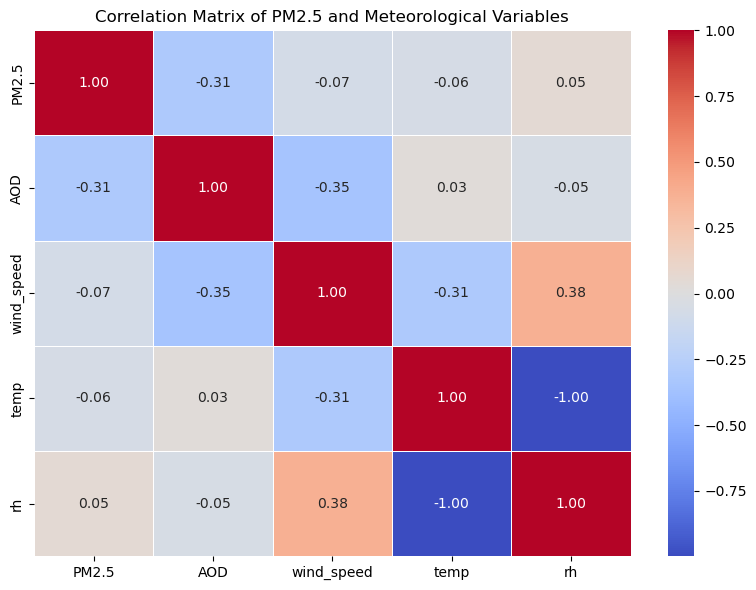

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Or check correlation matrix
print(matched_df[['PM2.5', 'AOD', 'wind_speed', 'temp', 'rh']].corr())
corr = matched_df[['PM2.5', 'AOD', 'wind_speed', 'temp', 'rh']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of PM2.5 and Meteorological Variables')
plt.tight_layout()
plt.show()


# Feature Selection and Preprocessing

In [11]:
features = ['AOD', 'lat', 'lon', 'U', 'V', 'wind_speed', 'temp', 'rh']
X = matched_df[features].dropna()
y = matched_df.loc[X.index, 'PM2.5']


# Train -Test Split 

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train Model 

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [14]:
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")


R² Score: 0.683
RMSE: 5.891


C:\Users\Nur Izfarwiza\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
importances = model.feature_importances_
for feature, score in zip(features, importances):
    print(f"{feature}: {score:.3f}")


AOD: 0.704
lat: 0.126
lon: 0.057
U: 0.028
V: 0.022
wind_speed: 0.026
temp: 0.023
rh: 0.013


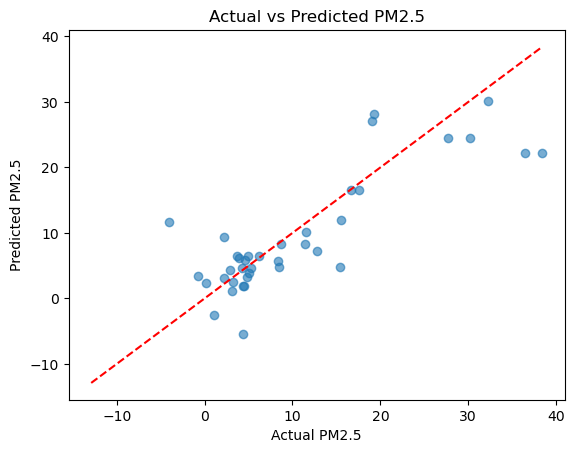

In [18]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.show()
